<a href="https://colab.research.google.com/github/XavierCarrera/Accomodation-reservation-prediction/blob/main/Reserve_Accomodation_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Problem Definition

[EN]

For this problem, we should take data from 7202 stays in order to predict the type of accomodation that a given user will choose. The final result will be a dataset with unlabel data taht will be classified by its features. Specifically, the original dataset has hotels and AirBnB as their accomodation options. 

We're using classifier algorithms for training our model. For more info, check the following documentatión: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

[ES]

Para este problema, debemos tomar los datos de 7202 estadías para predecir que tipo de acomodación elegirá un usuario dado. El resultado final será un dataset con datos no etiquetados que serán clasificados según sus características. Específicamente, el dataset original tiene hoteles y AirBnB como sus opciones de acomodación. 

Usamos algoritmos de clasificación para entrenar nuestro modelo. Para más información, mira la siguiente documentación: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [146]:
x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/db/train_data.txt", sep=" ", header = None)
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/db/DataAcomodacion.csv", encoding="latin-1")

In [147]:
test

,id,duracion_estadia,genero,edad,niños,codigo_destino,tipo_acomodacion
0,1013321,2,F,38.0,0.0,US,NaN
1,1009487,6,M,37.0,0.0,ES,NaN
2,1002727,1,M,37.0,1.0,ES,NaN
3,1001135,5,F,50.0,0.0,UK,NaN
4,1000796,4,F,42.0,1.0,AR,NaN
...,...,...,...,...,...,...,...
4224,1007287,3,M,NaN,0.0,ES,NaN
4225,1009717,4,F,35.0,NaN,NL,NaN
4226,1012540,7,F,NaN,1.0,PE,NaN
4227,1000617,4,M,48.0,0.0,UK,NaN


In [148]:
test.drop(["id", "tipo_acomodacion"], axis=1, inplace=True)
test

,duracion_estadia,genero,edad,niños,codigo_destino
0,2,F,38.0,0.0,US
1,6,M,37.0,0.0,ES
2,1,M,37.0,1.0,ES
3,5,F,50.0,0.0,UK
4,4,F,42.0,1.0,AR
...,...,...,...,...,...
4224,3,M,NaN,0.0,ES
4225,4,F,35.0,NaN,NL
4226,7,F,NaN,1.0,PE
4227,4,M,48.0,0.0,UK


In [149]:
test.isnull().sum()

duracion_estadia      0
genero                0
edad                415
niños               438
codigo_destino      413
dtype: int64

In [150]:
test.dropna(inplace=True)
test

,duracion_estadia,genero,edad,niños,codigo_destino
0,2,F,38.0,0.0,US
1,6,M,37.0,0.0,ES
2,1,M,37.0,1.0,ES
3,5,F,50.0,0.0,UK
4,4,F,42.0,1.0,AR
...,...,...,...,...,...
4221,5,F,48.0,1.0,PE
4222,6,M,37.0,0.0,COL
4223,4,M,42.0,1.0,UK
4227,4,M,48.0,0.0,UK


In [151]:
x

,0,1
0,[REG],Registro 1
1,[REG],1010286
2,[REG],7
3,[REG],F
4,[REG],40
...,...,...
78939,[REG],F
78940,[REG],49
78941,[REG],1
78942,[REG],IT


# Data Engineering

[EN]

The first problem we face is that our training data was given as a .txt format. After transforming into a dataframe, we have two columns. Only one is valuable and is given in a single column. Our objective here will be to turn this on a workable dataframe, with the appropiate datatype.

[ES]

El primer problema al que nos enfrentamos es que nuestros datos de entrenamientos estan dados en un formato .txt. Después de transformarlo en un dataframe, tenemos dos columnas. Solo una es de valor y está dada en una sola columna. Nuestro objetivo aquí es convertirla en un dataframe con elq ue se pueda trabajar, con el tipo de datos apropiado.

In [152]:
x.drop(x.columns[0], axis=1, inplace=True)
x

,1
0,Registro 1
1,1010286
2,7
3,F
4,40
...,...
78939,F
78940,49
78941,1
78942,IT


[EN]

With the following code, we divide the column each time it detects the string 'Registro'. This turns into an array. In the second line, we concat all the string to form the dataframe. We finish transposing the dataframe in order to have the proper columns and rows.

[ES]

Con el siguiente código, estamos dividiendo la columna cada vez que detecte el string 'Registro'. Este se convierte en un arreglo. En la segunda línea estamos concatenando todos los strings para formar el dataframe. Terminamos transponiendo el dataframe para tener las columnas y filas adecuadas. 

In [153]:
arrCollection = x[1].str.extract('(Registro.*)').ffill()[0].to_numpy()
df = x.set_index([x.groupby(arrCollection)[1].cumcount()-1,
                     arrCollection])[1].unstack().iloc[1:,:]

train = df.T
train

,0,1,2,3,4,5,6
Registro 1,1010286,7,F,40,0,COL,AirBnB
Registro 10,1006149,5,F,31,NaN,AR,AirBnB
Registro 100,1007317,5,M,42,0,PE,AirBnB
Registro 1000,1007185,6,M,46,1,IT,Hotel
Registro 1001,1002065,4,F,43,0,COL,AirBnB
...,...,...,...,...,...,...,...
Registro 995,1011356,4,F,33,1,AR,Hotel
Registro 996,1008195,4,F,37,1,ES,Hotel
Registro 997,1005338,6,M,38,0,AR,Hotel
Registro 998,1014092,7,M,42,1,AR,Hotel


In [154]:
train.drop(train.columns[0], axis=1, inplace=True)
train

,1,2,3,4,5,6
Registro 1,7,F,40,0,COL,AirBnB
Registro 10,5,F,31,NaN,AR,AirBnB
Registro 100,5,M,42,0,PE,AirBnB
Registro 1000,6,M,46,1,IT,Hotel
Registro 1001,4,F,43,0,COL,AirBnB
...,...,...,...,...,...,...
Registro 995,4,F,33,1,AR,Hotel
Registro 996,4,F,37,1,ES,Hotel
Registro 997,6,M,38,0,AR,Hotel
Registro 998,7,M,42,1,AR,Hotel


In [155]:
train = train.rename(columns={1: "duracion_estadia", 2: "genero", 3: "edad", 4: "niños", 5: "codigo_destino", 6: "tipo_acomodacion"})
train

,duracion_estadia,genero,edad,niños,codigo_destino,tipo_acomodacion
Registro 1,7,F,40,0,COL,AirBnB
Registro 10,5,F,31,NaN,AR,AirBnB
Registro 100,5,M,42,0,PE,AirBnB
Registro 1000,6,M,46,1,IT,Hotel
Registro 1001,4,F,43,0,COL,AirBnB
...,...,...,...,...,...,...
Registro 995,4,F,33,1,AR,Hotel
Registro 996,4,F,37,1,ES,Hotel
Registro 997,6,M,38,0,AR,Hotel
Registro 998,7,M,42,1,AR,Hotel


In [156]:
train.isnull().sum()

duracion_estadia      0
genero                0
edad                994
niños               971
codigo_destino      996
tipo_acomodacion      0
dtype: int64

In [157]:
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True) 
train

,duracion_estadia,genero,edad,niños,codigo_destino,tipo_acomodacion
0,7,F,40,0,COL,AirBnB
1,5,M,42,0,PE,AirBnB
2,6,M,46,1,IT,Hotel
3,4,F,43,0,COL,AirBnB
4,5,M,30,1,PE,AirBnB
...,...,...,...,...,...,...
7197,4,F,33,1,AR,Hotel
7198,4,F,37,1,ES,Hotel
7199,6,M,38,0,AR,Hotel
7200,7,M,42,1,AR,Hotel


[EN]

All data is given as an object type. We need to turn some of them into integers for the EDA process and training our model. 

[ES]

Toda nuestra data esta dada como un tipo objeto. Debemos convertirla en número enteros para el análisis exploratorio de datos y entrenar nuestro modelo.

In [158]:
train.dtypes

duracion_estadia    object
genero              object
edad                object
niños               object
codigo_destino      object
tipo_acomodacion    object
dtype: object

In [159]:
train['duracion_estadia'] = train.duracion_estadia.astype(int)
train['niños'] = train.niños.astype(int)
train['edad'] = train.edad.astype(int)

In [160]:
train.dtypes

duracion_estadia     int64
genero              object
edad                 int64
niños                int64
codigo_destino      object
tipo_acomodacion    object
dtype: object

# Exploratory Data Analysis

[EN]

The first step will be to make an descriptive analysis of all guests. 

Note: The children feature has boolean entries. 

[ES]

El primer paso será hacer un análisis descriptivo de todos nuestros huéspedes. 

Nota: El feature "niños" tiene entradas booleanas.

In [ ]:
train.duracion_estadia.describe()

count    7202.000000
mean        3.986948
std         1.728832
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        12.000000
Name: duracion_estadia, dtype: float64

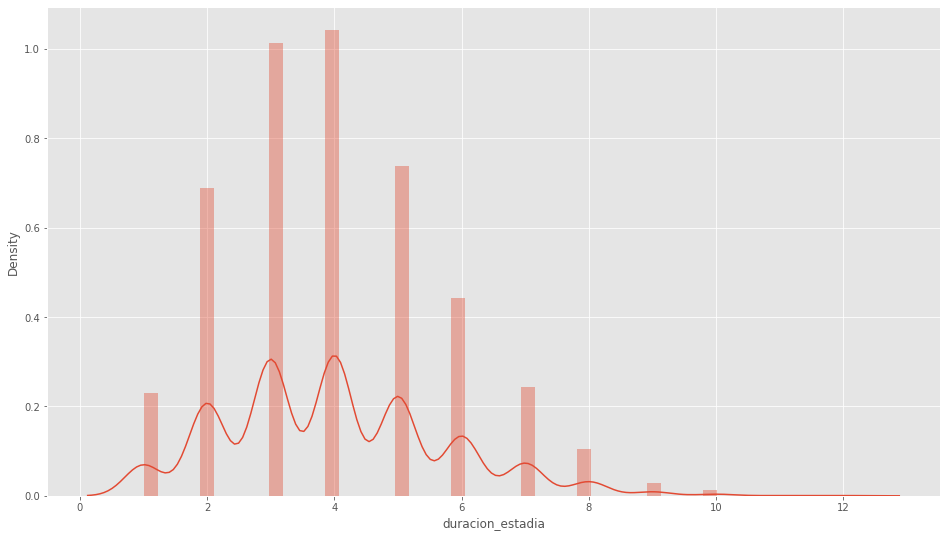

In [ ]:
sns.distplot(train["duracion_estadia"])

In [ ]:
train.genero.value_counts().sort_values()

M    3575
F    3627
Name: genero, dtype: int64

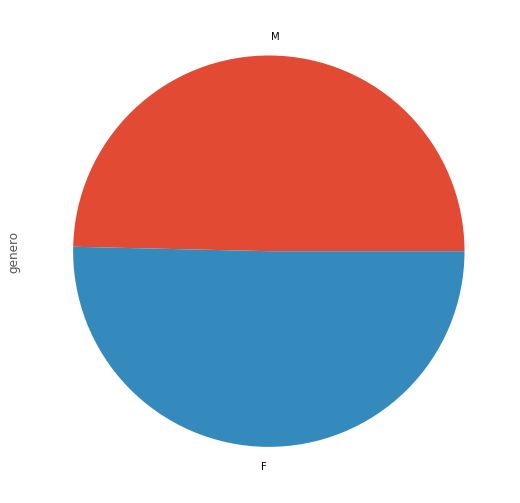

In [ ]:
train.genero.value_counts().sort_values().plot(kind = "pie")

In [ ]:
train.edad.describe()

count    7202.000000
mean       40.393641
std         5.065561
min        22.000000
25%        37.000000
50%        40.000000
75%        44.000000
max        59.000000
Name: edad, dtype: float64

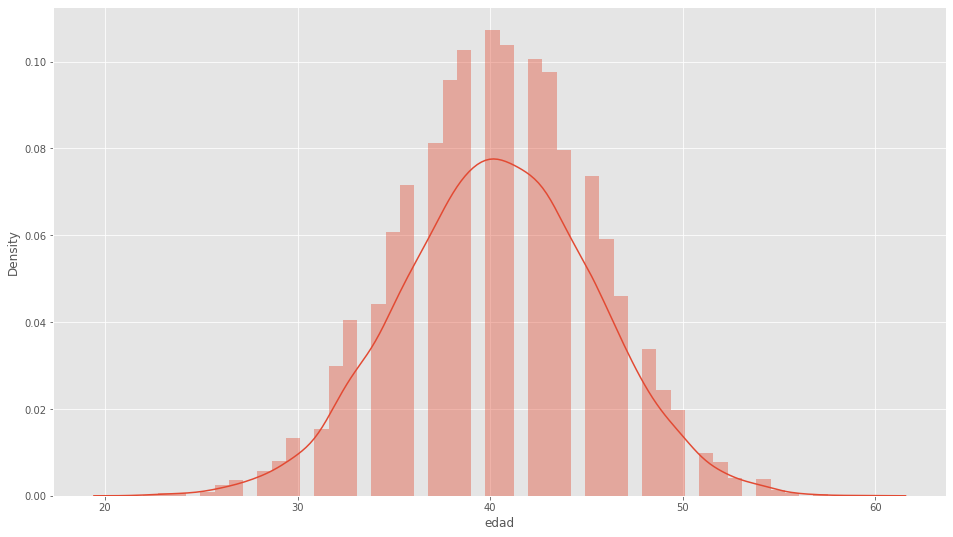

In [ ]:
sns.distplot(train["edad"])

In [ ]:
train.codigo_destino.value_counts().sort_values()

ES     858
UK     875
NL     890
AR     895
PE     898
IT     919
COL    920
US     947
Name: codigo_destino, dtype: int64

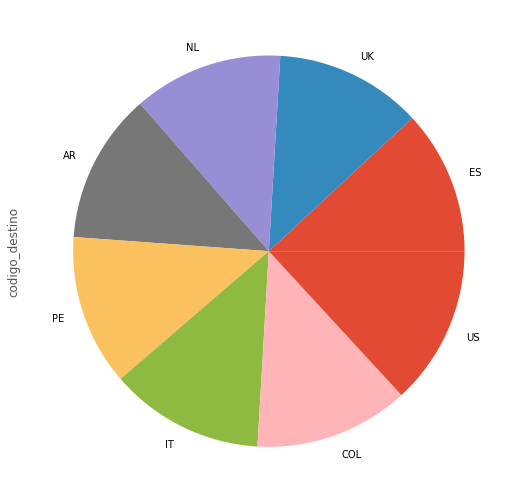

In [ ]:
train.codigo_destino.value_counts().sort_values().plot(kind = "pie")

In [ ]:
train.niños.value_counts().sort_values()

0    3574
1    3628
Name: niños, dtype: int64

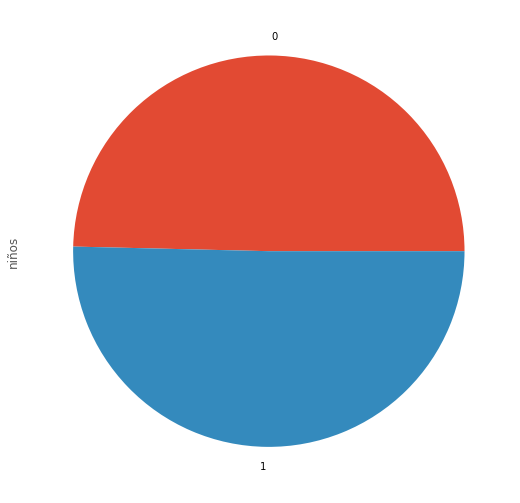

In [ ]:
train.niños.value_counts().sort_values().plot(kind = "pie")

In [ ]:
train.tipo_acomodacion.value_counts().sort_values()

AirBnB    3118
Hotel     4084
Name: tipo_acomodacion, dtype: int64

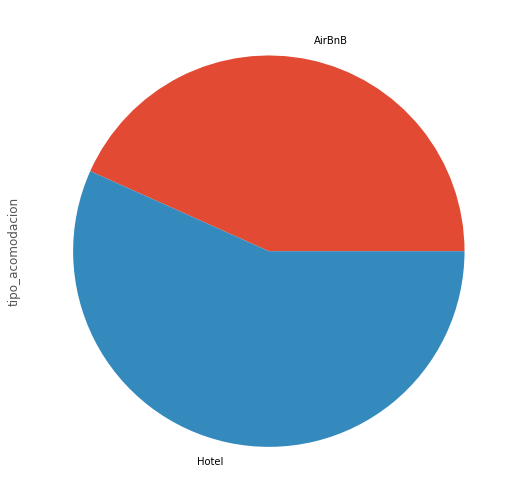

In [ ]:
train.tipo_acomodacion.value_counts().sort_values().plot(kind = "pie")

[EN]

First observation: There's are an equivalent number for gender, children and destination code entries. An obvious pattern amid them might be complicated to spot. 

Second observation: Most reservations were made my middle age people, with our interquartile range being between 37 and 44 y.o. 

Third observation: The interquartile range for the stay lengths is from 3 to 5 nights. 

Fourth observation: Most reservations were made for hotels -- over a quarter more than for AirBnB.

[ES]

Primera observación: Hay un número equivalente para los features género, niños y código de destino. Un patrón obvio entre ellas podría ser difícil de detectar.

Segunda observación: La mayoría de reservaciones fueron hechas por gente de mediana edad, siendo el rango intercuartílico entre 37 y 44 años de edad.

Tercera observación: El rango intercuartílico para las estadías es de 3 a 5 noches.

Cuarta observación: La mayoría de reservaciones fueron hechas para hoteles, con una cuarte parte más que AirBnB.

**Correlation Analysis**

In [ ]:
eda = train
le = LabelEncoder()
eda['genero'] = le.fit_transform(eda['genero'])
eda['codigo_destino'] = le.fit_transform(eda['codigo_destino'])
eda['tipo_acomodacion'] = le.fit_transform(eda['tipo_acomodacion'])
eda

,duracion_estadia,genero,edad,niños,codigo_destino,tipo_acomodacion
0,7,0,40,0,1,0
1,5,1,42,0,5,0
2,6,1,46,1,3,1
3,4,0,43,0,1,0
4,5,1,30,1,5,0
...,...,...,...,...,...,...
7197,4,0,33,1,0,1
7198,4,0,37,1,2,1
7199,6,1,38,0,0,1
7200,7,1,42,1,0,1


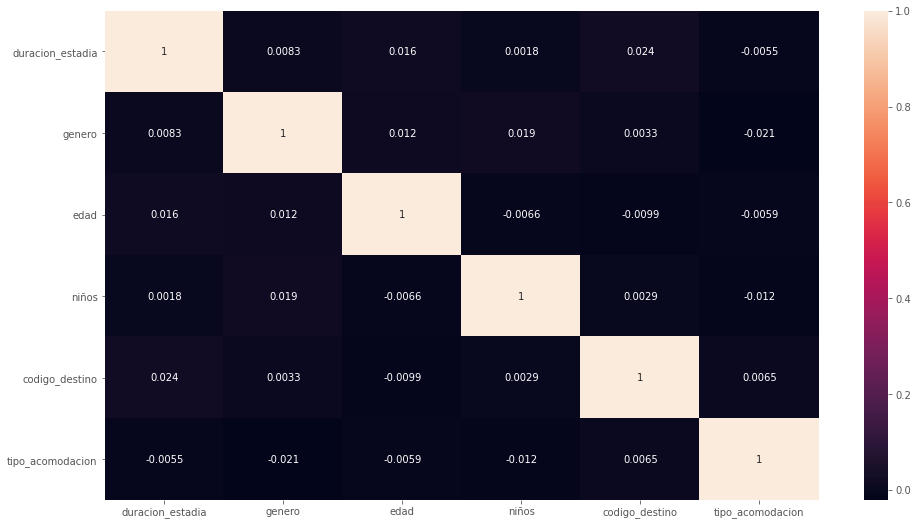

In [ ]:
corr = eda.corr()
sns.heatmap(corr, annot = True, yticklabels=corr.columns, xticklabels=corr.columns)

In [ ]:
eda2 = pd.get_dummies(data = train, columns=["genero", "codigo_destino"])
eda2['tipo_acomodacion'] = le.fit_transform(eda2['tipo_acomodacion'])

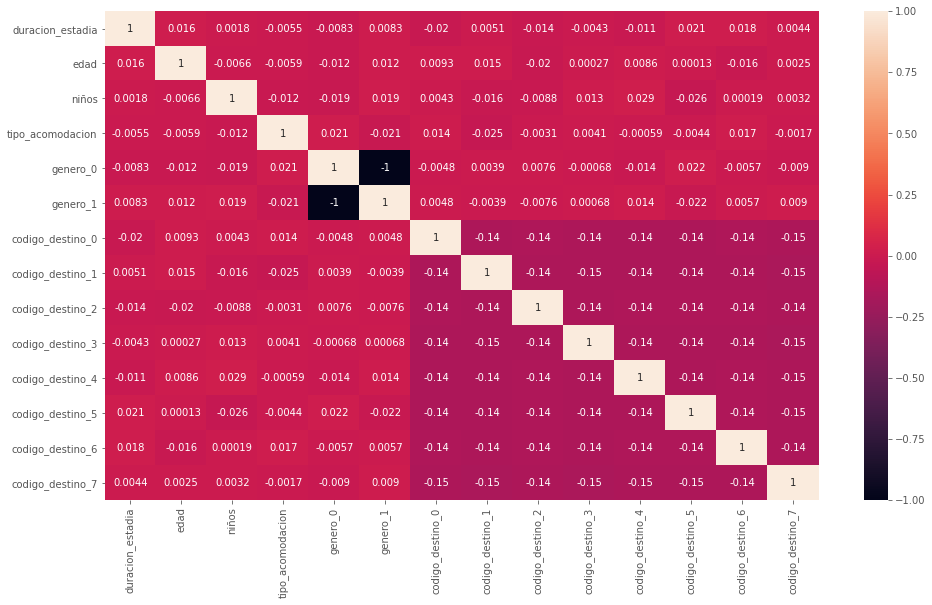

In [ ]:
corr = eda2.corr()
sns.heatmap(corr, annot = True, yticklabels=corr.columns, xticklabels=corr.columns)

[EN]

Fifth observation: There's no clear correlation between features. We might need all of them for training our model. 

[ES]

Quinta observación: No hay una correlación clara entre features. Podríamos necesitarlas todas para entrenar nuestro modelo. 

**Hotel Users Analysis**

[EN]

We'll do an analysis of people that have reserved in hotels. For this, we'll transform the AirBnB value into 0 and hotels into 1. In the first part we'll do a demographic analysis of people opting for hotels and later we'll measure the booking chances for a person given its features.

Note: For the latter, a value close to 1 means that the user might prefer reserving at a hotel.

[ES]

Haremos una análisis de las personas que han reservado en hoteles. Para esto, hemos transformado AirBnB en un valor 0 y los hoteles en un valor 1. En la primera parte hacemos un análisis demográfico de las personas que optaron por hoteles y luego medimos las posibilidades de que una persona eliga esto dado sus características. 

Nota: Para el último, un valor cercano a 1 significa que nuestro usuario prefiera reservar en un hotel. 

In [ ]:
hotel = train[train["tipo_acomodacion"] == 1]
air = train[train["tipo_acomodacion"] == 0]
print(hotel.describe())
print(air.describe())

       duracion_estadia         edad        niños  tipo_acomodacion
count       4084.000000  4084.000000  4084.000000            4084.0
mean           3.978697    40.367532     0.498531               1.0
std            1.738272     5.087944     0.500059               0.0
min            1.000000    22.000000     0.000000               1.0
25%            3.000000    37.000000     0.000000               1.0
50%            4.000000    40.000000     0.000000               1.0
75%            5.000000    44.000000     1.000000               1.0
max           12.000000    56.000000     1.000000               1.0
       duracion_estadia         edad        niños  tipo_acomodacion
count       3118.000000  3118.000000  3118.000000            3118.0
mean           3.997755    40.427838     0.510584               0.0
std            1.716607     5.036704     0.499968               0.0
min            1.000000    24.000000     0.000000               0.0
25%            3.000000    37.000000     0.00000

In [ ]:
print(hotel.genero.value_counts().sort_values())
print(air.genero.value_counts().sort_values())

M    1990
F    2094
Name: genero, dtype: int64
F    1533
M    1585
Name: genero, dtype: int64


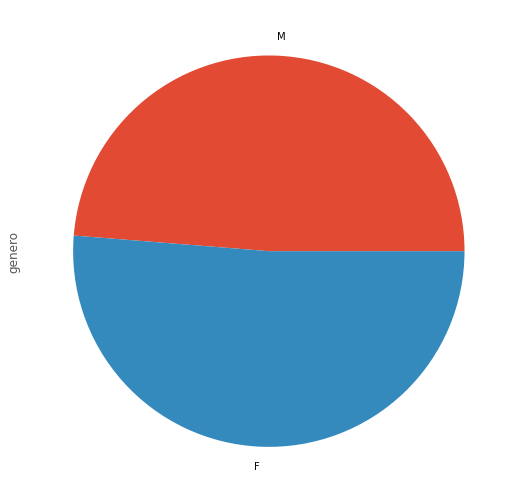

In [ ]:
hotel.genero.value_counts().sort_values().plot(kind = "pie")

In [ ]:
print(hotel.codigo_destino.value_counts().sort_values())
print(air.codigo_destino.value_counts().sort_values())

ES     483
COL    492
NL     504
PE     504
UK     516
AR     524
IT     526
US     535
Name: codigo_destino, dtype: int64
UK     359
AR     371
ES     375
NL     386
IT     393
PE     394
US     412
COL    428
Name: codigo_destino, dtype: int64


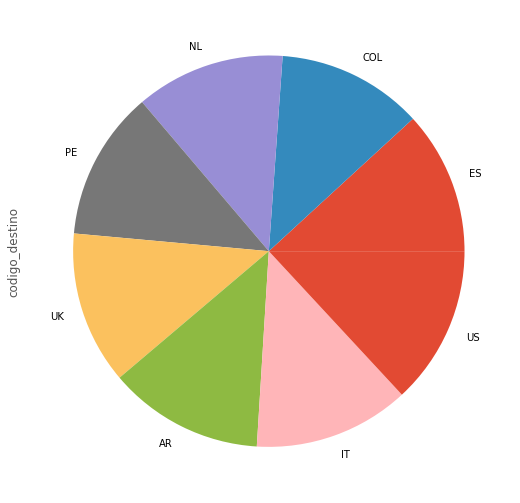

In [ ]:
hotel.codigo_destino.value_counts().sort_values().plot(kind = "pie")

[EN]

First observation: The demographics of the people booking in hotels is almost equal to the entire data population.

[ES]

Primera observación: La demografía de la persona reservando en hoteles es casí igual a la población total den uestros datos. 

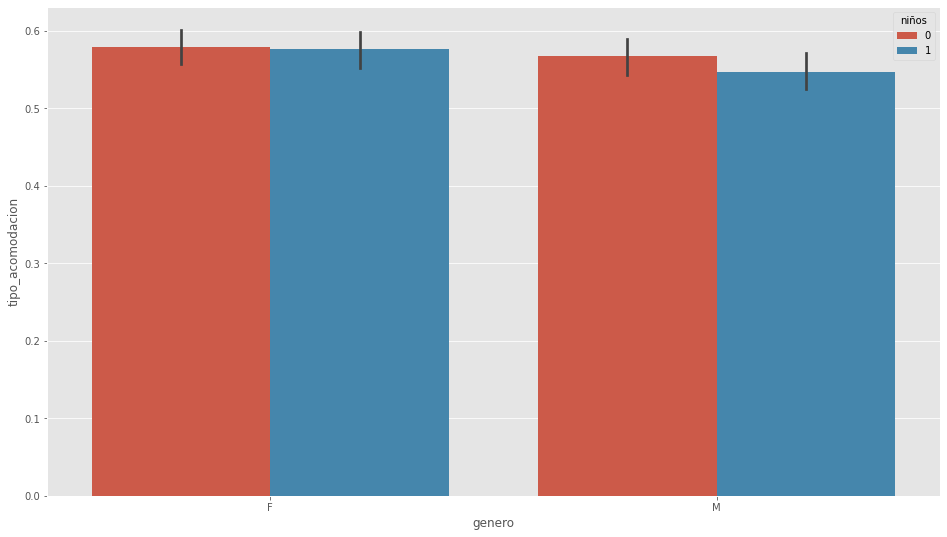

In [ ]:
train['tipo_acomodacion'] = le.fit_transform(eda2['tipo_acomodacion'])
sns.barplot(x="genero", y="tipo_acomodacion", data=train, hue = "niños")

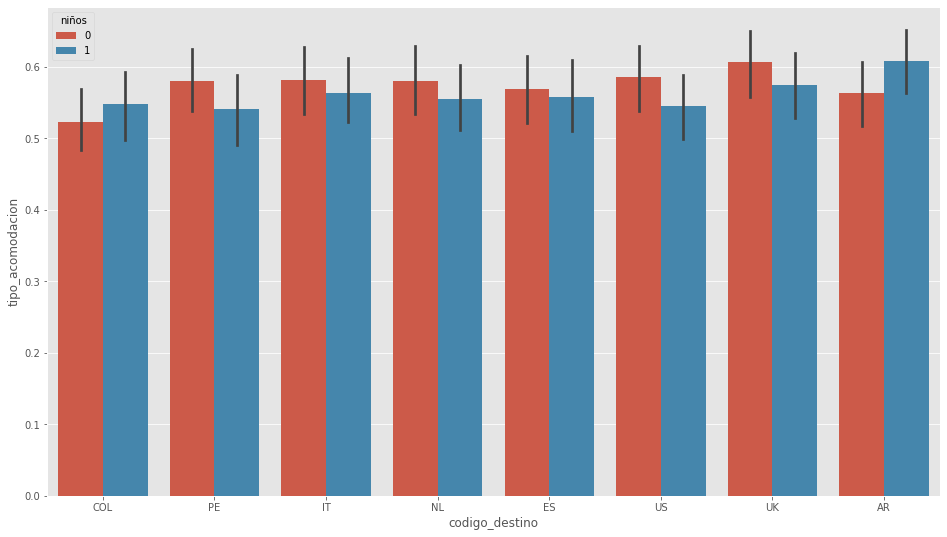

In [ ]:
sns.barplot(x="codigo_destino", y="tipo_acomodacion", data=train, hue = "niños")

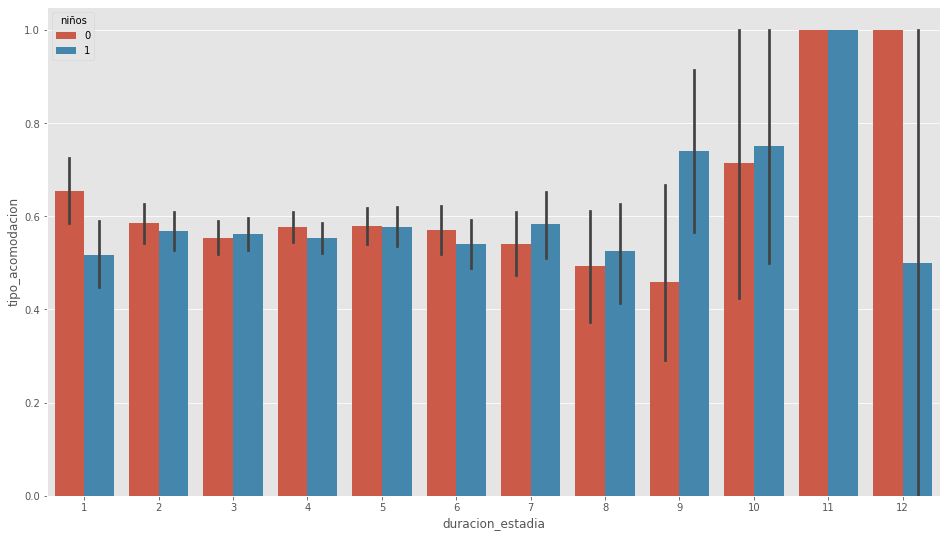

In [ ]:
sns.barplot(x="duracion_estadia", y="tipo_acomodacion", data=train, hue = "niños")

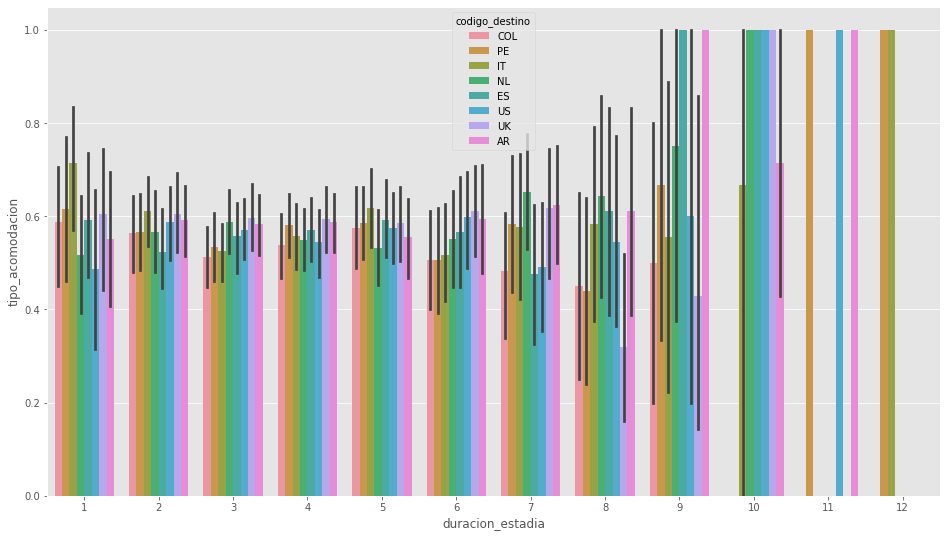

In [ ]:
sns.barplot(x="duracion_estadia", y="tipo_acomodacion", data=train, hue = "codigo_destino")

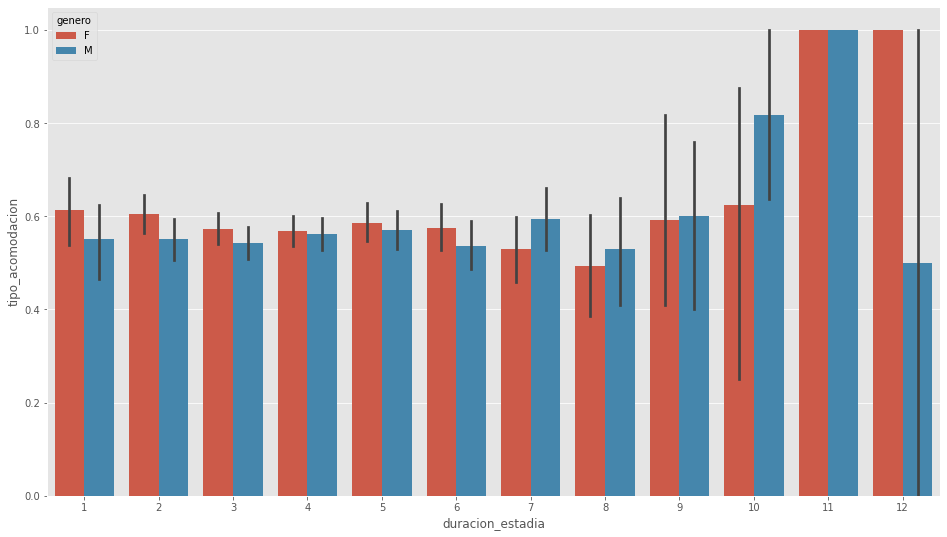

In [ ]:
sns.barplot(x="duracion_estadia", y="tipo_acomodacion", data=train, hue = "genero")

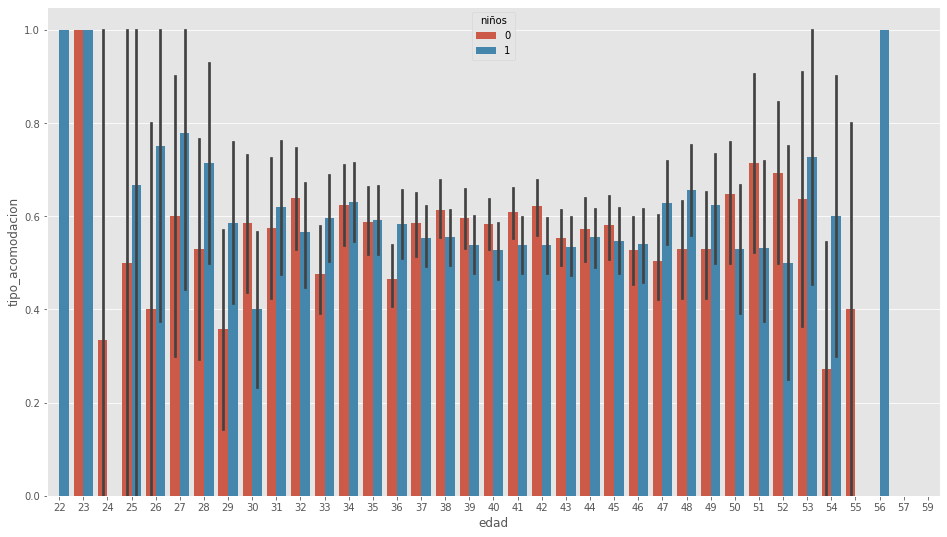

In [ ]:
sns.barplot(x="edad", y="tipo_acomodacion", data=train, hue = "niños")

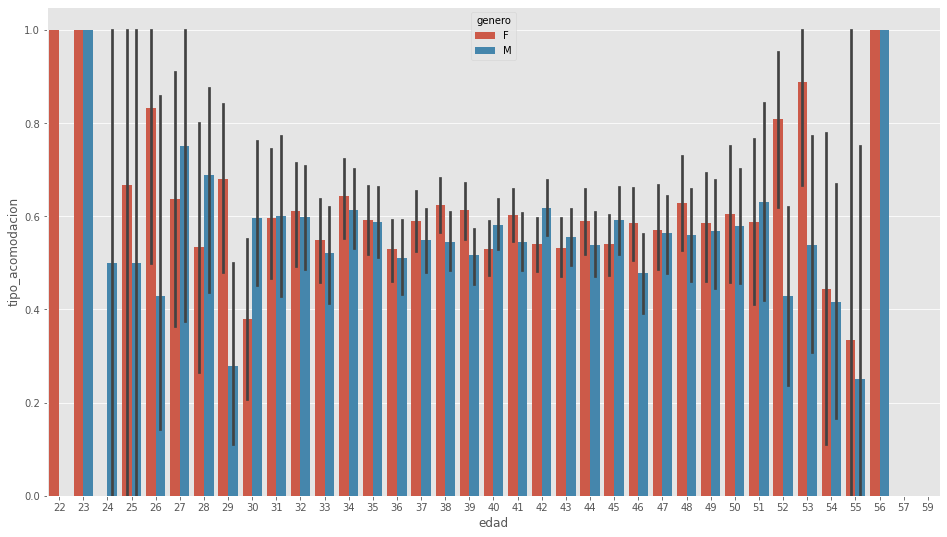

In [ ]:
sns.barplot(x="edad", y="tipo_acomodacion", data=train, hue = "genero")

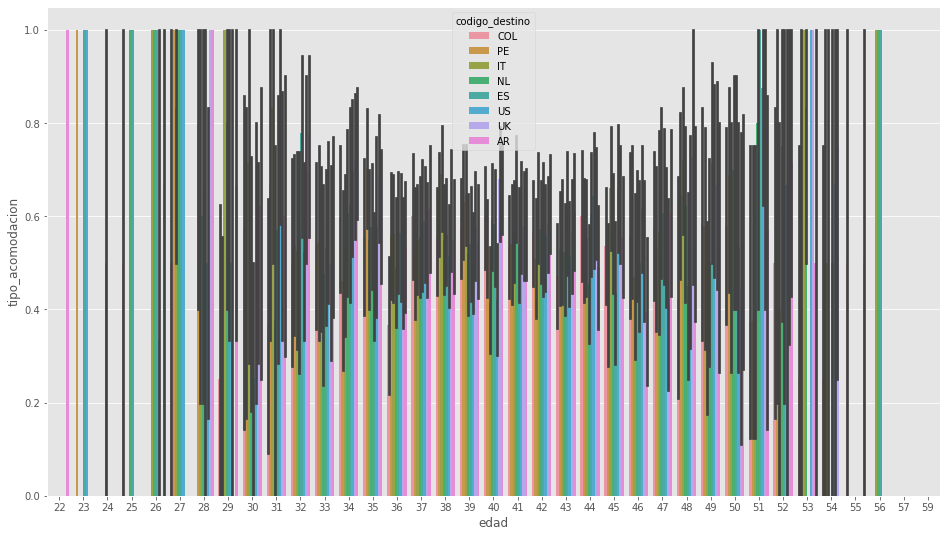

In [ ]:
sns.barplot(x="edad", y="tipo_acomodacion", data=train, hue = "codigo_destino")

[EN]

Second observation: There's not much difference on the bookings made with children when we cross that data with bookings made by gender and per destination.

Third observation: Hotel bookings tend to be more frequent for long stays.

Fourth observation: Middle age individuals (around 40 y.o.) tend to prefer staying in AirBnBs, while youngsters and older people in hotels

[ES]

Segunda observación: No hay mucha diferencia entre las reservaciones hechas con niños cuando se cruza con datos de reservaciones hechas por género y para destinaciones.

Tercera observación: Las reservaciones de hotel tienden a ser más frecuentes para estadías largas. 

Cuarta observación: Individuso de edad media (alrededor de 40 años) tienden a quedarse en AirBnBs, mientras los jóvenes y personas mayores en hoteles.

# Feature Engineering

[EN]

We'll encode the categorical features into numerican values by using get_dummies that will return boolean values. The target column will be transformed into a column with boolean values.

Later on, we'll divide our data into train and test. We finish creating k-folds to cross-validate our results.

[ES]

Encodearemos los features categóricos en valores numéricos usando get_dummies que nos regresa valores booleanos. La columna target se transformará en una columna con booleanos. 

Posteriormente, dividiremos nuestros datos de entrenamiento y pruebas. Terminamos creando nuestros k-folds para hacer una validación cruzada.

In [162]:
model = pd.get_dummies(data = train, columns=["genero", "codigo_destino"])
model['tipo_acomodacion'] = le.fit_transform(model["tipo_acomodacion"])
model

,duracion_estadia,edad,niños,tipo_acomodacion,genero_F,genero_M,codigo_destino_AR,codigo_destino_COL,codigo_destino_ES,codigo_destino_IT,codigo_destino_NL,codigo_destino_PE,codigo_destino_UK,codigo_destino_US
0,7,40,0,0,1,0,0,1,0,0,0,0,0,0
1,5,42,0,0,0,1,0,0,0,0,0,1,0,0
2,6,46,1,1,0,1,0,0,0,1,0,0,0,0
3,4,43,0,0,1,0,0,1,0,0,0,0,0,0
4,5,30,1,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7197,4,33,1,1,1,0,1,0,0,0,0,0,0,0
7198,4,37,1,1,1,0,0,0,1,0,0,0,0,0
7199,6,38,0,1,0,1,1,0,0,0,0,0,0,0
7200,7,42,1,1,0,1,1,0,0,0,0,0,0,0


In [163]:
test_model = pd.get_dummies(data = test, columns=["genero", "codigo_destino"])
test_model

,duracion_estadia,edad,niños,genero_F,genero_M,codigo_destino_AR,codigo_destino_COL,codigo_destino_ES,codigo_destino_IT,codigo_destino_NL,codigo_destino_PE,codigo_destino_UK,codigo_destino_US
0,2,38.0,0.0,1,0,0,0,0,0,0,0,0,1
1,6,37.0,0.0,0,1,0,0,1,0,0,0,0,0
2,1,37.0,1.0,0,1,0,0,1,0,0,0,0,0
3,5,50.0,0.0,1,0,0,0,0,0,0,0,1,0
4,4,42.0,1.0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,5,48.0,1.0,1,0,0,0,0,0,0,1,0,0
4222,6,37.0,0.0,0,1,0,1,0,0,0,0,0,0
4223,4,42.0,1.0,0,1,0,0,0,0,0,0,1,0
4227,4,48.0,0.0,0,1,0,0,0,0,0,0,1,0


In [164]:
X = model.drop(["tipo_acomodacion"], axis = 1)
y = model["tipo_acomodacion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# Model Training

[EN]

We'll use five classification algorithms in order to see which one provides the best outcome. We'll further assess the model with a confusion matrix.

[ES]

Usaremos cinco algoritmos de clasificación para ver cual da un mejor resultado. Evaluaremos a profundidad el modelo con una matriz de confusión. 

**Decision Tree**

In [165]:
clf = tree.DecisionTreeClassifier().fit(X, y)
score = cross_val_score(clf, X, y, cv = k_fold, n_jobs = 1, scoring = "accuracy")
print(score)

[0.78085992 0.80859917 0.75277778 0.7625     0.775      0.76805556
 0.76388889 0.7875     0.76111111 0.77638889]


In [166]:
score.mean()

0.7736681306826938

**K-Nearest Neighbors**

In [167]:
clf = KNeighborsClassifier().fit(X, y)
score = cross_val_score(clf, X, y, cv = k_fold, n_jobs = 1, scoring = "accuracy")
print(score)

[0.78779473 0.74757282 0.75972222 0.76666667 0.74861111 0.75416667
 0.75277778 0.75972222 0.76805556 0.75138889]


In [168]:
score.mean()

0.7596478656187394

**Random Forest Classifier**

In [169]:
clf = RandomForestClassifier().fit(X, y)
score = cross_val_score(clf, X, y, cv = k_fold, n_jobs = 1, scoring = "accuracy")
print(score)

[0.81137309 0.82801664 0.79722222 0.77638889 0.79861111 0.78472222
 0.78611111 0.8        0.78888889 0.79861111]


In [170]:
score.mean()

0.7969945292032671

**Multi-layer Perceptron Classifier**

In [171]:
clf = MLPClassifier().fit(X, y)
score = cross_val_score(clf, X, y, cv = k_fold, n_jobs = 1, scoring = "accuracy")
print(score)

[0.84188627 0.82108183 0.8        0.80972222 0.66666667 0.80694444
 0.54166667 0.83055556 0.6125     0.82916667]


In [172]:
score.mean()

0.7560190322083525

**C-Support Vector Classification**

In [173]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X, y)
score = cross_val_score(clf, X, y, cv = k_fold, n_jobs = 1, scoring = "accuracy")
print(score)

[0.80443828 0.7628294  0.74722222 0.7625     0.77222222 0.7875
 0.77361111 0.77222222 0.80138889 0.76527778]


In [174]:
score.mean()

0.7749212128216982

**Prediction**

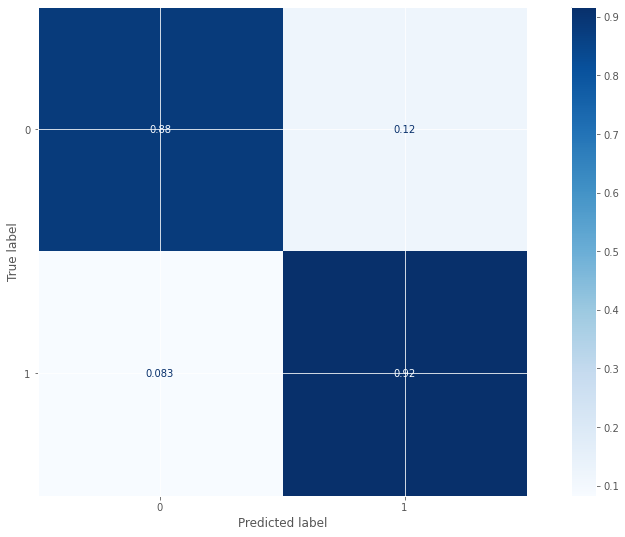

In [178]:
matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show(matrix)
plt.show()

[EN]

Random forest gave the best global score. Furthemore, when assessing it with a confussion matrix we see that it was good at preventing false positive and false negatives. 

We finishing by predicting the values for the original test dataset.

[ES]

Random forest dió el mejor resultado global. Además, al evaluarlo con una matriz de confusión vemos que fue bueno para prevenir falsos positvos y falsos negativos.

Terminamos prediciendo los valores de nuestro dataset original de prueba.


In [175]:
clf = clf = RandomForestClassifier().fit(X, y)
test_model["tipo_acomodacion"] = clf.predict(test_model)
test_model

,duracion_estadia,edad,niños,genero_F,genero_M,codigo_destino_AR,codigo_destino_COL,codigo_destino_ES,codigo_destino_IT,codigo_destino_NL,codigo_destino_PE,codigo_destino_UK,codigo_destino_US,tipo_acomodacion
0,2,38.0,0.0,1,0,0,0,0,0,0,0,0,1,1
1,6,37.0,0.0,0,1,0,0,1,0,0,0,0,0,1
2,1,37.0,1.0,0,1,0,0,1,0,0,0,0,0,0
3,5,50.0,0.0,1,0,0,0,0,0,0,0,1,0,1
4,4,42.0,1.0,1,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,5,48.0,1.0,1,0,0,0,0,0,0,1,0,0,0
4222,6,37.0,0.0,0,1,0,1,0,0,0,0,0,0,1
4223,4,42.0,1.0,0,1,0,0,0,0,0,0,1,0,1
4227,4,48.0,0.0,0,1,0,0,0,0,0,0,1,0,1


# Model Evaluation

[EN]

We finish this exercise by comparing the results of our original test dataset with the training dataset.

[ES]

Terminamos este ejercicios comparando los resultados demográficos de nuestro data set original de pruebas con el dataset de entrenamiento. 

In [ ]:
result = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/db/DataAcomodacion.csv", encoding="latin-1")
result.drop(["id", "tipo_acomodacion"], axis=1, inplace=True)
result.dropna(inplace=True)
result["tipo_acomodacion"] = test_model["tipo_acomodacion"]
result

,duracion_estadia,genero,edad,niños,codigo_destino,tipo_acomodacion
0,2,F,38.0,0.0,US,0
1,6,M,37.0,0.0,ES,1
2,1,M,37.0,1.0,ES,0
3,5,F,50.0,0.0,UK,1
4,4,F,42.0,1.0,AR,0
...,...,...,...,...,...,...
4221,5,F,48.0,1.0,PE,0
4222,6,M,37.0,0.0,COL,1
4223,4,M,42.0,1.0,UK,1
4227,4,M,48.0,0.0,UK,1


In [ ]:
hotel = result[result["tipo_acomodacion"] == 1]
air = result[result["tipo_acomodacion"] == 0]
print(hotel.describe())
print(air.describe())

       duracion_estadia         edad        niños  tipo_acomodacion
count       1695.000000  1695.000000  1695.000000            1695.0
mean           3.991150    40.440708     0.516814               1.0
std            1.761598     5.132356     0.499865               0.0
min            1.000000    22.000000     0.000000               1.0
25%            3.000000    37.000000     0.000000               1.0
50%            4.000000    40.000000     1.000000               1.0
75%            5.000000    44.000000     1.000000               1.0
max           12.000000    57.000000     1.000000               1.0
       duracion_estadia         edad        niños  tipo_acomodacion
count       1384.000000  1384.000000  1384.000000            1384.0
mean           3.924855    40.599711     0.487717               0.0
std            1.710455     4.887323     0.500030               0.0
min            1.000000    22.000000     0.000000               0.0
25%            3.000000    37.000000     0.00000

In [ ]:
print(hotel.genero.value_counts().sort_values())
print(air.genero.value_counts().sort_values())

M    847
F    848
Name: genero, dtype: int64
F    674
M    710
Name: genero, dtype: int64


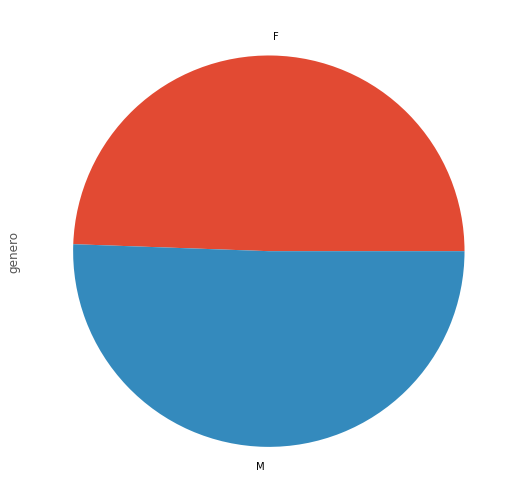

In [ ]:
result.genero.value_counts().sort_values().plot(kind = "pie")

In [133]:
print(hotel.codigo_destino.value_counts().sort_values())
print(air.codigo_destino.value_counts().sort_values())

NL     191
COL    206
US     207
ES     208
PE     208
AR     211
UK     225
IT     239
Name: codigo_destino, dtype: int64
AR     154
UK     157
US     164
IT     175
PE     175
ES     184
COL    187
NL     188
Name: codigo_destino, dtype: int64


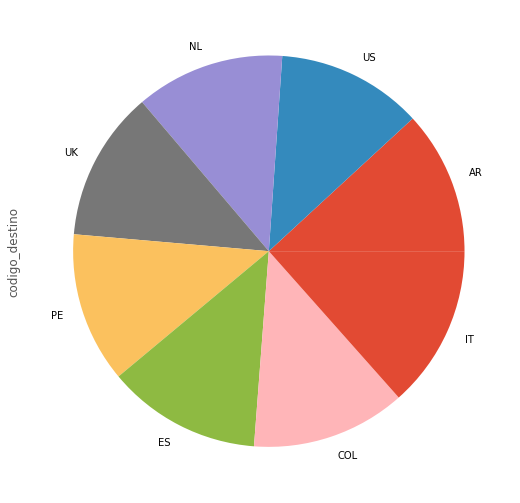

In [134]:
result.codigo_destino.value_counts().sort_values().plot(kind = "pie")

[EN]

The predictions made on our original test dataset reflect well on the our training dataset. We can thus say that our model had an overall fine performance.

We finish this exercise by creating dummy data to further test our model.

[ES]

Las predicciones hechas en nuestro dataset original de prueba reflejan bien el dataset original. Podemos entonces decir que nuestro modelo tuvo un buen desempeño.

Terminamos este ejercicio creando datos dummies para terminar de testear nuestro modelo. 

In [176]:
testing_data = [[4, 25, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                [9, 43, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]

for i, pred in enumerate(clf.predict(testing_data)):
  print("Acomodación recomendada para el usuario No.{}: {:,}".format(i+1, pred))

Acomodación recomendada para el usuario No.1: 0
Acomodación recomendada para el usuario No.2: 1
